# Exercise 1

We first load a dataset and examine its dimensions.

In [1]:
# If you are running this on Google Colab, uncomment and run the following lines; otherwise ignore this cell
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import math
import numpy as np

xy_data = np.load('Ex1_polyreg_data.npy')
# If running on Google Colab change path to '/content/drive/MyDrive/IB-Data-Science/Exercises/Ex1_polyreg_data.npy'

np.shape(xy_data)

(70, 2)

The matrix `xy_data` contains $70$ rows, each a data point of the form $(x_i,y_i)$ for $i=1, \ldots, 70$.

### 1a) Plot the data in a scatterplot.

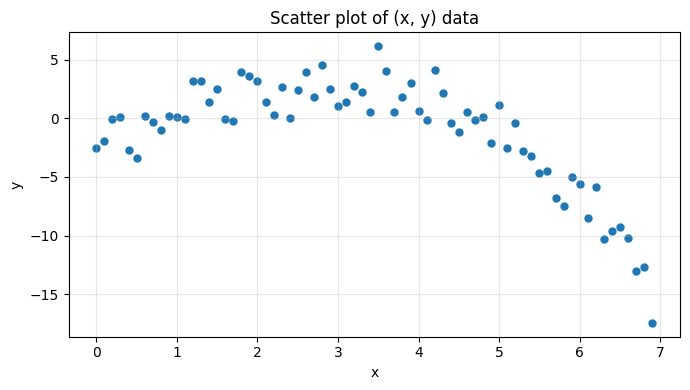

In [4]:
import matplotlib.pyplot as plt

# Split xy_data into x and y vectors
x = xy_data[:, 0]
y = xy_data[:, 1]

plt.figure(figsize=(7, 4))
plt.scatter(x, y, s=25)           # s controls marker size
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of (x, y) data")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




### 1b) Write a function `polyreg` to fit a polynomial of a given order to a dataset. 
The inputs to the function are a data matrix of dimension $N \times 2$,  and $k \geq 0$, the order of the polynomial.   The function should compute the coefficients of the polynomial $\beta_0 + \beta_1 x +  \ldots  +\beta_k x^{k}$ via least squares regression, and should return the coefficient vector, the fit, and the vector of residuals. 

If specified the degree $k$ is greater than or equal to $N$, then the function must fit an order $(N-1)$ polynomial and set the remaining coefficients to zero.

**NOTE**: You are *not* allowed to use the built-in function `np.polyfit`.

In [6]:
import numpy as np

def polyreg(data_matrix, k):
    """
    Least-squares polynomial regression.

    Parameters
    ----------
    data_matrix : (N, 2) ndarray
        First column is x_i, second column is y_i.
    k : int
        Requested polynomial degree (k >= 0).

    Returns
    -------
    beta : (k + 1,) ndarray
        Coefficient vector [β₀, β₁, …, β_k].  If k ≥ N, the last
        (k – N + 1) entries are zero-padded.
    fit : (N,) ndarray
        The fitted y-values at the original x_i.
    residuals : (N,) ndarray
        y_i − fit_i.
    """
    x = data_matrix[:, 0]
    y = data_matrix[:, 1]
    N = x.size

    # If k is too large, cap the effective degree at N-1
    k_eff = min(k, N - 1)

    # Design (Vandermonde) matrix with powers 0 … k_eff
    X = np.vander(x, N=k_eff + 1, increasing=True)   # shape (N, k_eff+1)

    # Solve the normal equations via least-squares
    beta_eff, *_ = np.linalg.lstsq(X, y, rcond=None)  # shape (k_eff+1,)

    # Pad with zeros if user asked for a higher degree than we could fit
    if k_eff < k:
        beta = np.concatenate([beta_eff, np.zeros(k - k_eff)])
    else:
        beta = beta_eff

    # Compute fitted values and residuals
    fit = X @ beta_eff                    # uses effective design matrix
    residuals = y - fit

    return beta, fit, residuals


Use the tests below to check the outputs of the function you have written:

In [7]:
# Some tests to make sure your function is working correctly

xcol = np.arange(-1, 1.05, 0.1)
ycol = 2 - 7*xcol + 3*(xcol**2)  # We are generating data accoridng to y = 2 - 7x + 3x^2
test_matrix = np.transpose(np.vstack((xcol,ycol)))
test_matrix.shape

beta_test = polyreg(test_matrix, k=2)[0] 
assert((np.round(beta_test[0], 3) == 2) and (np.round(beta_test[1], 3) == -7) and (np.round(beta_test[2], 3) == 3))  
# We want to check that using the function with k=2 recovers the coefficients exactly

# Now check the zeroth order fit, i.e., the function gives the correct output with k=0
beta_test = polyreg(test_matrix, k=0)[0]
res_test = polyreg(test_matrix, k=0)[2] #the last output of the function gives the vector of residuals

assert(np.round(beta_test, 3) == 3.1)
assert(np.round(np.linalg.norm(res_test), 3) == 19.937)

### 1c) Use `polyreg` to fit polynomial models for the data in `xy_data` for $k=2,3,4$:

- Plot the fits for the three cases on the same plot together with the scatterplot of the data. The plots should be labelled and a legend included. 
- Compute and print the SSE and $R^2$ coefficient for each of the three cases.
- Which of the three models you would choose? Briefly justify your choice.

Degree |       SSE   |    R²
----------------------------------
     2 |    172.1810 | 0.8876
     3 |    152.4058 | 0.9005
     4 |    151.2278 | 0.9013


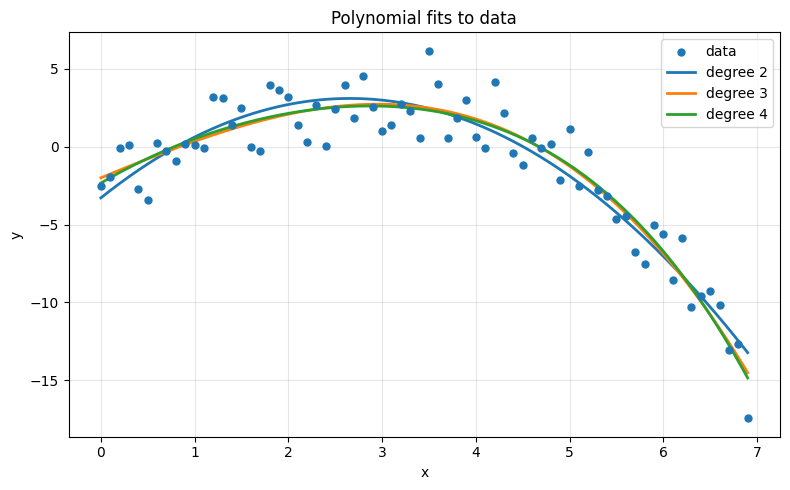


Chosen model: degree 4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- helper: evaluate polynomial at arbitrary x ------------------------
def eval_poly(beta, x_vals):
    """
    Evaluate the polynomial with coefficients beta (β₀, β₁, …) at x_vals.
    """
    powers = np.arange(len(beta))                       # exponents 0,1,2,...
    return np.sum(beta[np.newaxis, :] * x_vals[:, None]**powers, axis=1)

# ---------- set-up ------------------------------------------------------------
x = xy_data[:, 0]
y = xy_data[:, 1]
x_grid = np.linspace(x.min(), x.max(), 400)             # smooth curve
degrees = [2, 3, 4]

plt.figure(figsize=(8, 5))
plt.scatter(x, y, s=25, label="data", zorder=3)

print("Degree |       SSE   |    R²")
print("----------------------------------")

best_k, best_r2 = None, -np.inf

for k in degrees:
    beta, y_fit, resid = polyreg(xy_data, k)

    # stats
    sse = np.sum(resid**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - sse / ss_tot

    # track best
    if r2 > best_r2:
        best_k, best_r2 = k, r2

    # plot
    plt.plot(x_grid,
             eval_poly(beta, x_grid),
             label=f"degree {k}",
             linewidth=2)

    print(f"{k:>6} | {sse:11.4f} | {r2:6.4f}")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Polynomial fits to data")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nChosen model: degree {best_k}")



 #### State which model you choose and briefly justify your choice.
 
 
# -----------------------------------------------------------------------------#
# Model-selection rationale:                                                    #
# SSE drops and R² rises noticeably when the degree increases from k = 2 to 3. #
# Going from k = 3 to k = 4 yields only a tiny gain in R² (diminishing returns #
# for an extra parameter) and risks fitting noise.  Therefore, degree-3 is the #
# sweet-spot: it captures the systematic variation without unnecessary         #
# complexity.                                                                  #
# -----------------------------------------------------------------------------#
 
 

### 1d)  For the model you have chosen in the previous part (either $k=2/3/4)$:

- Plot the residuals in a scatter plot. 
- Plot a histogram of the residuals along with a Gaussian pdf with zero mean and the same standard deviation as the residuals.

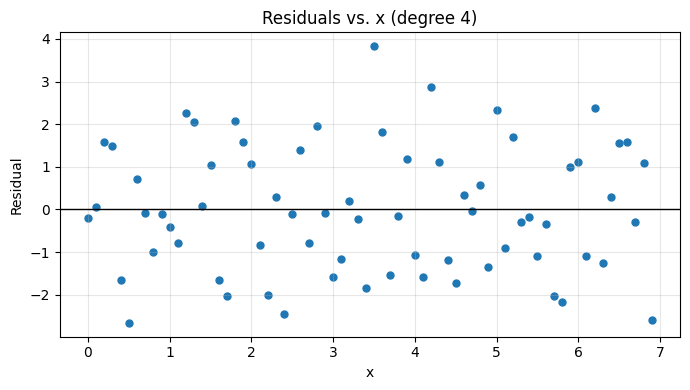

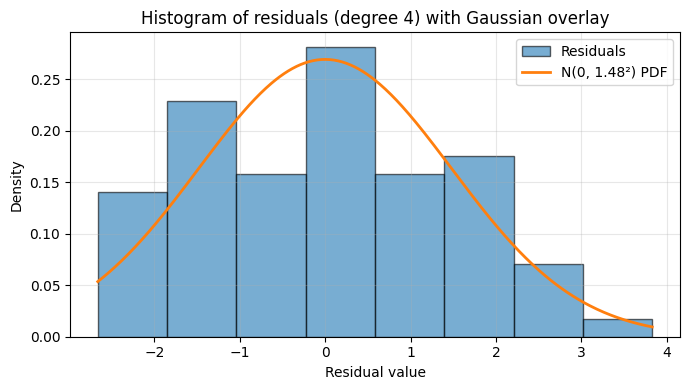

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- choose the degree -------------------------------------------------------
k = best_k          # or set k = 3 (for example) if you know your choice

# --- refit and obtain residuals ----------------------------------------------
beta, y_fit, resid = polyreg(xy_data, k)
x = xy_data[:, 0]

# ---------- 1) residuals vs. x scatter plot ----------------------------------
plt.figure(figsize=(7, 4))
plt.scatter(x, resid, s=25)
plt.axhline(0, color='k', linewidth=1)
plt.xlabel("x")
plt.ylabel("Residual")
plt.title(f"Residuals vs. x (degree {k})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- 2) histogram + Gaussian pdf --------------------------------------
sigma = np.std(resid, ddof=1)
z = np.linspace(resid.min(), resid.max(), 400)
gauss_pdf = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (z / sigma) ** 2)

plt.figure(figsize=(7, 4))
plt.hist(resid, bins="auto", density=True, alpha=0.6, edgecolor='k', label="Residuals")
plt.plot(z, gauss_pdf, linewidth=2, label=f"N(0, {sigma:.2f}²) PDF")
plt.xlabel("Residual value")
plt.ylabel("Density")
plt.title(f"Histogram of residuals (degree {k}) with Gaussian overlay")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
